In [1]:
from propy import PyPro
import pandas as pd
import numpy as np
import seaborn as sns
from pycaret.classification import *
from modlamp.descriptors import PeptideDescriptor, GlobalDescriptor
from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [2]:
f = open("E:/AMPlist1.txt", "r")
seq=f.read()
seq_list_AMP=seq.split(">")
seq_list_AMP.pop(0)

''

In [3]:
f1 = open("E:/nonAMPlist1.txt", "r")
seq=f1.read()
seq_list_non_AMP=seq.split(">")
seq_list_non_AMP.pop(0)

''

In [4]:
seq_count_neg=len(seq_list_non_AMP)

In [5]:
seq_count=len(seq_list_AMP)

In [6]:
def list_to_df(prd,DFtype='non'):
    prd_df=None
    # Assigning IDs of sequence to the dataframe 
    prd_id=[]
    ids='prd'
    if DFtype =="neg":
        ids='neg'
    elif DFtype =="pos":
        ids='pos'
    else:
        pass
    for i in range (len(prd)):
        prd_id.append(ids+" "+str(i))
    # Making objects for descriptor calculation
    d_listaa=[]
    d_listad=[]
    for i in range(len(prd)):
        DesObject = PyPro.GetProDes(prd[i])
        dic_AAC=DesObject.GetAAComp()
        dict_DPC=DesObject.GetDPComp()
        
        d_listaa.append(dic_AAC)
        d_listad.append(dict_DPC)
    # Formation of dataframe        
    DesObject = PyPro.GetProDes(prd[0])
    dic_AAC=DesObject.GetAAComp()
    dict_DPC=DesObject.GetDPComp()

    cols_AAC=dic_AAC.keys()
    cols_DPC=dict_DPC.keys()
    main_df_AAC=pd.DataFrame(columns=cols_AAC)
    main_df_DPC=pd.DataFrame(columns=cols_DPC)
    for i in range (len(prd)):
        df1=pd.DataFrame(d_listaa[i],index=[prd_id[i]])
        main_df_AAC=pd.concat([main_df_AAC,df1],axis=0)

        df2=pd.DataFrame(d_listad[i],index=[prd_id[i]])
        main_df_DPC=pd.concat([main_df_DPC,df2],axis=0)
    
    # Actual discriptor calculation
    esn_des=[]
    iso_point=[]
    hydro_res=[]
    net_charge=[]
    chrg_desity=[]
    helix=[]
    sheet=[]
    for i in range(len(prd)):
        desc = PeptideDescriptor(prd[i],'eisenberg')
        desc.calculate_moment()
        esn_des.append(desc.descriptor)

        glob = GlobalDescriptor(prd[i])
        glob.isoelectric_point()
        iso_point.append(glob.descriptor)
        
        hyd= GlobalDescriptor(prd[i])
        hyd.hydrophobic_ratio()
        hydro_res.append(hyd.descriptor)
        
        nt= GlobalDescriptor(prd[i])
        nt.calculate_charge(ph=7.4, amide=True)
        net_charge.append(nt.descriptor)
        
        ch_density = GlobalDescriptor(prd[i])
        ch_density.charge_density(ph=6, amide=True)
        chrg_desity.append(ch_density.descriptor)
        
        pro_analysis = ProteinAnalysis(prd[i])
        sec_struc = pro_analysis.secondary_structure_fraction()
        #helix.append(sec_struc[0])
        #sheet.append(sec_struc[2])
        
    # adding values to dataframe
    for n in range(len(prd)):
        esn_des[n]=esn_des[n][0][0]
        iso_point[n]=iso_point[n][0][0]
        hydro_res[n]=hydro_res[n][0][0]
        net_charge[n]=net_charge[n][0][0]
        chrg_desity[n]=chrg_desity[n][0][0]
        
    main_df_DPC['Eisenberg']=pd.Series(esn_des,index=main_df_DPC.index)
    main_df_DPC['Iso Electric']=pd.Series(iso_point,index=main_df_DPC.index)
    main_df_DPC['Hydrophobic']=pd.Series(hydro_res,index=main_df_DPC.index)
    main_df_DPC['Net Charge']=pd.Series(net_charge,index=main_df_DPC.index)
    main_df_DPC['Charge Density']=pd.Series(chrg_desity,index=main_df_DPC.index)
    #main_df_DPC['Helix']=pd.Series(helix,index=main_df_DPC.index)
    #main_df_DPC['Sheet']=pd.Series(sheet,index=main_df_DPC.index)
    prd_df=main_df_DPC
    #
    prd_df=pd.concat([main_df_AAC,prd_df],axis=1)
    #Assigning the target labels
    if DFtype =="neg":
        prd_df['Target']=pd.Series(["Negative" for i in range(len(prd))],index=prd_df.index)
        
    elif DFtype =="pos":
        prd_df['Target']=pd.Series(["Positive" for i in range(len(prd))],index=prd_df.index)
    else:
        pass
    # returning the dataframe
    return prd_df

In [7]:
pos_df=list_to_df(seq_list_AMP,'pos')

In [13]:
neg_df=list_to_df(seq_list_non_AMP,'neg')

In [14]:
full_df=pd.concat([neg_df,pos_df],axis=0)

In [15]:
model=setup(data=full_df,target='Target')

,Description,Value
0,session_id,8527
1,Target,Target
2,Target Type,Binary
3,Label Encoded,"Negative: 0, Positive: 1"
4,Original Data,"(9923, 426)"
5,Missing Values,False
6,Numeric Features,425
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [16]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8540,0.9266,0.8642,0.8453,0.8545,0.7081,0.7085,4.3230
xgboost,Extreme Gradient Boosting,0.8475,0.9221,0.8511,0.8432,0.8471,0.6951,0.6952,13.7880
rf,Random Forest Classifier,0.8472,0.9047,0.8491,0.8442,0.8464,0.6945,0.6948,2.8710
et,Extra Trees Classifier,0.8458,0.8726,0.8450,0.8446,0.8446,0.6916,0.6919,3.7850
gbc,Gradient Boosting Classifier,0.8375,0.9094,0.8442,0.8310,0.8374,0.6749,0.6752,7.0850
qda,Quadratic Discriminant Analysis,0.8180,0.8614,0.8314,0.8077,0.8191,0.6361,0.6368,0.8750
lda,Linear Discriminant Analysis,0.7944,0.8524,0.8398,0.7682,0.8021,0.5891,0.5921,1.1340
ada,Ada Boost Classifier,0.7901,0.8697,0.7855,0.7903,0.7879,0.5801,0.5803,1.6630
ridge,Ridge Classifier,0.7702,0.0000,0.7980,0.7541,0.7751,0.5407,0.5420,0.2100
lr,Logistic Regression,0.7685,0.8298,0.7899,0.7553,0.7719,0.5371,0.5381,7.9710


In [15]:
gbc=create_model("lightgbm")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8676,0.9483,0.8588,0.8739,0.8663,0.7352,0.7354
1,0.8489,0.9225,0.8386,0.8559,0.8472,0.6978,0.6980
2,0.8518,0.9279,0.8732,0.8370,0.8547,0.7036,0.7043
3,0.8547,0.9394,0.8703,0.8436,0.8567,0.7094,0.7097
4,0.8489,0.9262,0.8473,0.8497,0.8485,0.6978,0.6978
5,0.8518,0.9351,0.8844,0.8293,0.8559,0.7037,0.7052
6,0.8674,0.9281,0.8931,0.8489,0.8704,0.7349,0.7359
7,0.8602,0.9308,0.8757,0.8487,0.8620,0.7205,0.7208
8,0.8401,0.9185,0.8497,0.8329,0.8412,0.6801,0.6803
9,0.8501,0.9164,0.8699,0.8361,0.8527,0.7003,0.7009


In [ ]:
tunned=tune_model(gbc)

IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,07:13:01
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


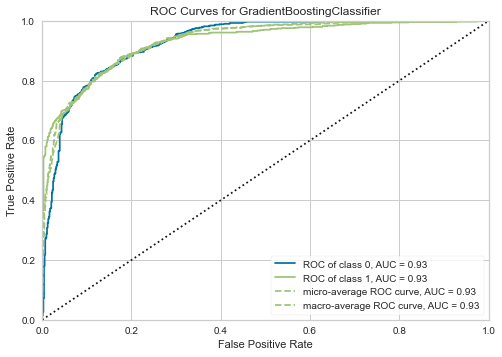

In [15]:
plot_model(gbc,'auc')

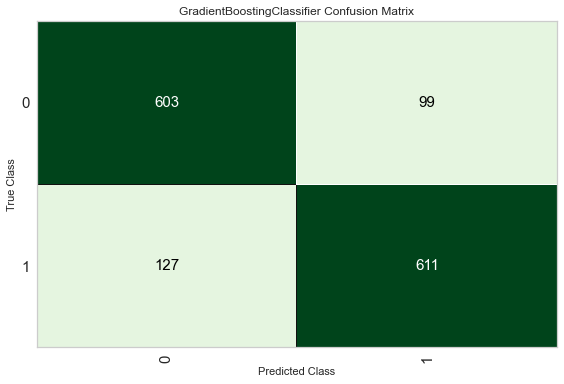

In [16]:
plot_model(gbc,'confusion_matrix')

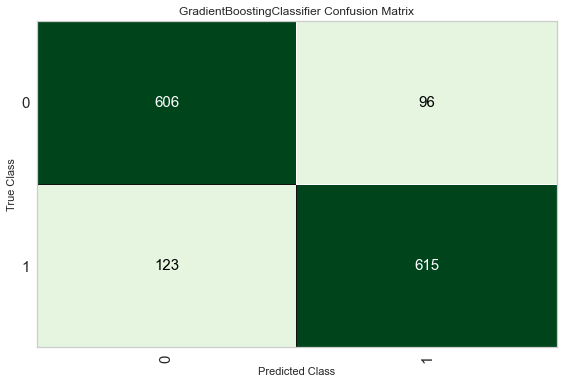

In [25]:
plot_model(tunned,'confusion_matrix')

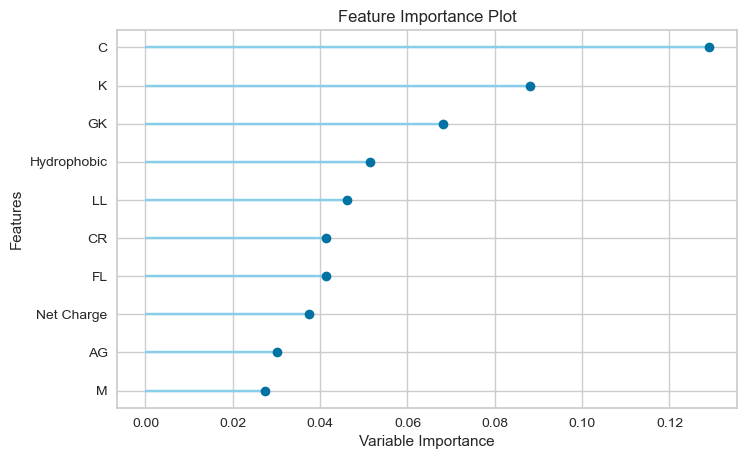

In [17]:
plot_model(gbc,'feature')

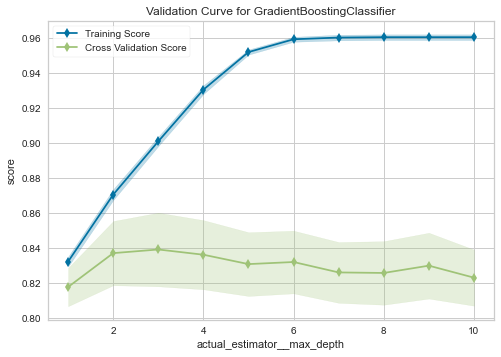

In [18]:
plot_model(gbc,'vc')

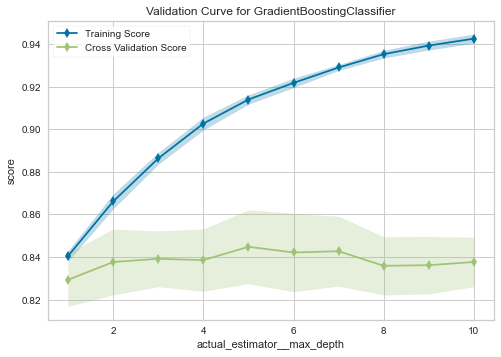

In [26]:
plot_model(tunned,'vc')

In [27]:
save_model(tunned,'FinalModel')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='Target',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strat...
                                             learning_rate=0.05, loss='deviance',
                                             max_depth=5, max_features='sqrt',
                                             max_leaf_nodes=None,
                                             mi

In [17]:
writer = pd.ExcelWriter('E:/10k dataset.xlsx')
# write dataframe to excel
full_df.to_excel(writer)
# save the excel
writer.save()

In [ ]:
def fitness_calculator(l_df,mod_addr):
    loded_mod = load_model(mod_addr)
    predic=predict_model(loded_mod,data=l_df)
    newdf=predic[ (predic['Label']=='Positive') & (predic['Score']>0.80)]
    new_ids=[]
    for df_id in range(len(newdf)):
        new_ids.append(int(newdf.index[df_id].split(' ')[1]))
    return new_ids

In [ ]:
def new_list_gen(m_list,idlist):
    n_lst=[]
    n_lst1=[]
    greater_ids=[]
    for a in idlist:
        n_lst.append(m_list[a])
    n_lst=list(set(n_lst)-set(seq_list_AMP))
    
    for a in range(len(n_lst)):
        if len(n_lst[a])>100:
            greater_ids.append(a)
        else:
            pass
    new_lst=n_lst
    for a in greater_ids:
        print(a,"  ",len(n_lst))
        n_lst1.append(n_lst[a])
        new_lst=list(set(n_lst)-set(n_lst1))
    return new_lst

In [ ]:
def population_gen(dlist:list,no_p):
    LST=[]
    p_1=[]
    p_2=[]
    o_s=[]
    for i in range(int(no_p)):
        if no_p> len(dlist):
            break
            print("Your population is less than your parent size")
        elif no_p< len(dlist):
            select_1=np.random.randint(len(dlist))
            select_2=np.random.randint(len(dlist))
            if select_1 == select_2:
                select_2=np.random.randint(len(dlist))
            p_1.append(dlist[select_1])
            p_2.append(dlist[select_2])           
    for j in range(no_p):
        if p_1[j]==p_2[j]:
            p_1[j]=p_1[j-1]
        elif p_1[j]!=p_2[j]:
            s1=np.random.randint(len(p_1[j]))
            if s1> len(p_2[j]):
                s2=int((len(p_2[j]))/2)
            elif s1<len(p_2[j]):
                s2=s1
            o_s1=p_1[j][:s1]
            o_s2=p_1[j][s2:]
            LST.append(s1)
            LST.append(" ")
            LST.append(s2)
            o_s.append(o_s1+o_s2)
    return o_s

In [ ]:
generations_list=[seq_list_AMP]
for q in range(5):
    list_of_pos=population_gen(generations_list[q],int(len(generations_list[q])*0.8))
    df1=list_to_df(lis t_of_pos)
    ids_lists=fitness_calculator(df1,'C:/Users/SabahatJamil/Final Model')
    list_new=new_list_gen(list_of_pos,ids_lists)
    generations_list.append(list_new)

In [ ]:
f=open("E:/Research/itr1.txt","a")
for j in range(len(generations_list[5])):
    g=generations_list[5]
    ac=">"
    f.write(ac)
    f.write(g[j])
f.close()

In [ ]:
generations_list=[seq_list_AMP]
for q in range(5):
    list_of_pos=population_gen(generations_list[q],int(len(generations_list[q])*0.8))
    df1=list_to_df(lis t_of_pos)
    ids_lists=fitness_calculator(df1,'C:/Users/SabahatJamil/Final Model')
    list_new=new_list_gen(list_of_pos,ids_lists)
    generations_list.append(list_new)

In [ ]:
f=open("E:/Research/itr2.txt","a")
for j in range(len(generations_list[5])):
    g=generations_list[5]
    ac=">"
    f.write(ac)
    f.write(g[j])
f.close()

In [57]:
f=open("E:/Research/results/itr1.txt")
para=f.read()
test_seq=para.split('>')
test_seq.pop(0)
f.close()

In [50]:
f=open("E:/Research/results/itr2.txt")
para2=f.read()
test_seq2=para.split('>')
test_seq2.pop(0)
f.close()

In [6]:
loaded_model=load_model("FinalModel")

Transformation Pipeline and Model Successfully Loaded


In [53]:
test_df2=list_to_df(test_seq2)

In [58]:
test_df=list_to_df(test_seq)

In [59]:
preds=predict_model(loaded_model,data=test_df)

In [54]:
preds2=predict_model(loaded_model,data=test_df2)

In [55]:
imp2=preds2[['C','K','M','GK','LL','CR','FL','Net Charge','Iso Electric','Hydrophobic','AG','Score']]

In [60]:
importants=preds[['C','K','M','GK','LL','CR','FL','Net Charge','Iso Electric','Hydrophobic','AG','Score']]

<AxesSubplot:>

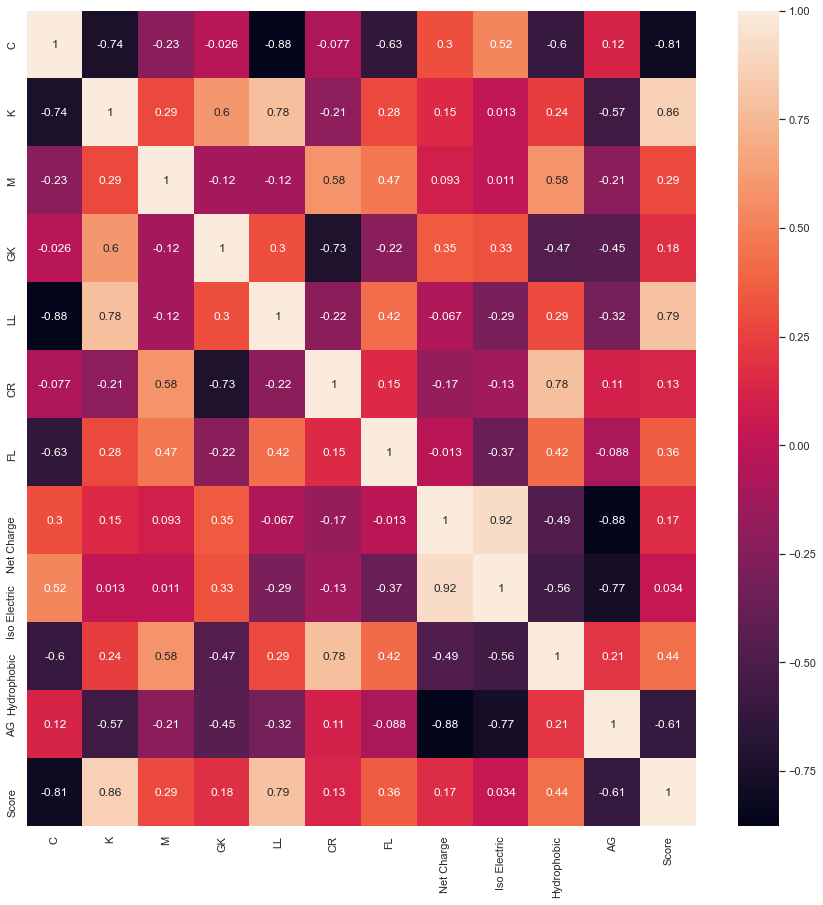

In [61]:
c2=imp2.corr()
sns.heatmap(c2,xticklabels=c2.columns,yticklabels=c2.columns,annot=True)


<AxesSubplot:>

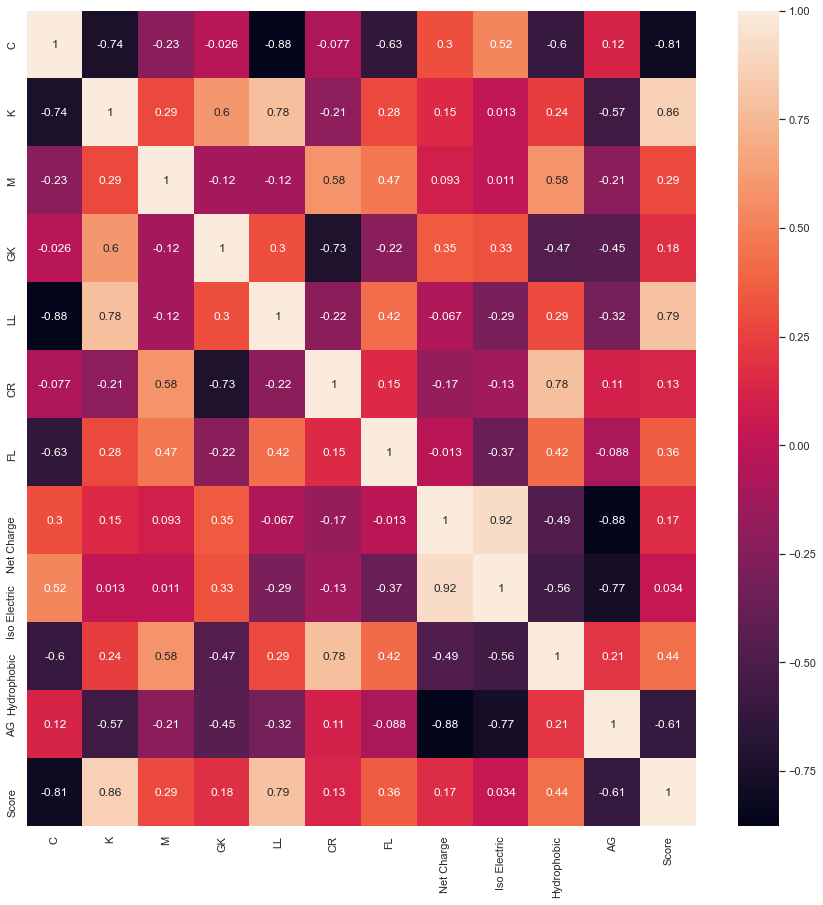

In [62]:
c1=importants.corr()
sns.heatmap(c1,xticklabels=c1.columns,yticklabels=c1.columns,annot=True)


<AxesSubplot:ylabel='C'>

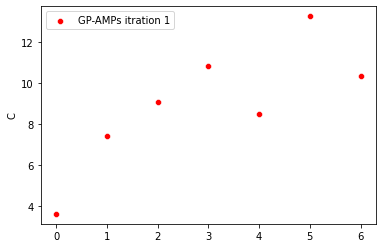

In [32]:
a='C'
sns.scatterplot(range(len(importants[a])),importants[a],marker='o',color='red',label='GP-AMPs itration 1')

<AxesSubplot:ylabel='K'>

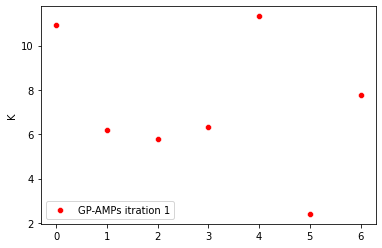

In [37]:
a='K'
sns.scatterplot(range(len(importants[a])),importants[a],marker='o',color='red',label='GP-AMPs itration 1')